# Reinforcement learning review (eps greedy and UCB1)
With the epsilon greedy algorithm, the proportion of explore to exploit is kept at a fixed value $\epsilon.$  Then, until termination:
$r=rand()$ 
if $r<\epsilon$:
     take random action #explore
else:  
     take action with best expected return #exploit

The disadvantage is that the ratio of explore to exploit is constant, so even if one case is obviously better, you still take a fixed proportion of the other cases.  An alternative is UCB1, where we modify the proportion we are choosing.  It makes use of the chernoff bound:
$$
P ( \hat \mu > \mu + \epsilon) \le \exp (-2 \epsilon^2 N),
$$
which, when extended to both sides, is
$$
P ( \vert \hat \mu - \mu \vert \le \epsilon) >1- \exp (-2 \epsilon^2 N).
$$
Letting $N, N_j$ represent the total number of games played so far and the total number of times we have chosen option j, we choose a bound related to the number of times we have played:
$$
\epsilon_j = \sqrt{ \frac{2 \log N}{N_j}}.
$$

We then always choose the bandit with the highest upper bound:
$$
bd_j=\hat \mu_j + \epsilon_j,
$$
which will change both with $N$ and $N_j$.  When an option is neglected, it's upper bound will increase, and the bound will tighten when an option is chosen.

# Bayesian relationship
With X as data and theta as the parameter value, 
$$
P(\theta \vert X) = \frac{P( X \vert \theta)P(\theta)}{P(X)}= \frac{P( X \vert \theta)P(\theta)}{Z}
$$
Where we use Z to show that we are thinking of the probability of the data as nothing more than a normalizing constant (since the data is given).  Meanwhile, $P( X \vert \theta), P(\theta), P(\theta \vert X)$ are the likelihood of the data given our current belief, prior (our current belief), and posterior (our belief after getting the data), respectively.


With conjugate distributions, the prior and posterior are from the same family of distributions.  For example, consider a bernoulli distribution
$$
P(X \vert \theta) = \Pi_{i=1}^N \theta^{x_i} (1-\theta)^{1-x_i}
$$
We model the distribution of theta as a beta distribution
$$
\theta \sim Beta(a,b) = \frac{\theta^{a-1} (1-\theta)^{b-1}}{B(a,b)}, \qquad \qquad B(a,b) = \frac{\Gamma(a) \Gamma(b)}{\Gamma(a+b)}
$$
Neglectling normalization, which does not depend on theta, 
$$
P(\theta \vert X) \propto \Pi_{i=1}^N \theta^{x_i} (1-\theta)^{1-x_i} \theta^{a-1} (1-\theta)^{b-1} = \theta^{a-1 + x} (1-\theta)^{b-1 +N-x} , \qquad x=\sum x_i
$$
Thus the posterior is also beta distributed.  Since the expectation of a beta is $a/(a+b)$, the expected number of 'heads' is exactly what one would expect it to be.  Meanwhile, the variance of theta is 
$$
var(\theta) = \frac{ab}{(a+b)^2(a+b+1)}
$$
With $a=b=1$, the beta is uniform on 0 to 1.

The Bayesian method of approaching multiple options (each bernoulli distributed) is:
Draw a random sample from the beta distributions of each option, then chose the option giving the maximum sample and update that distribution.


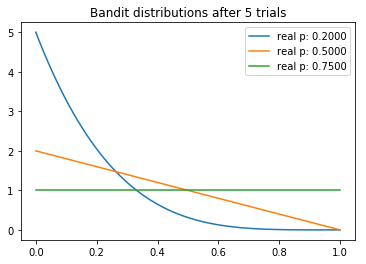

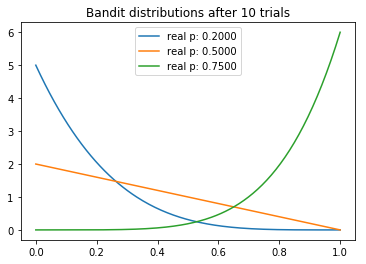

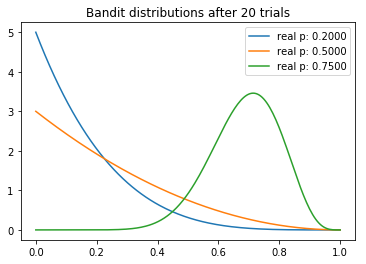

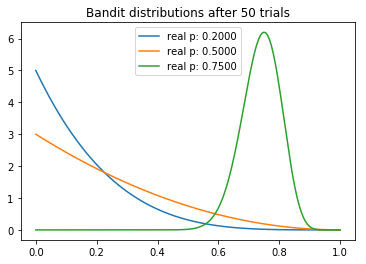

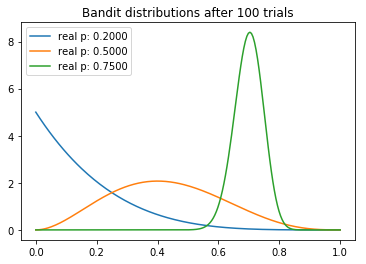

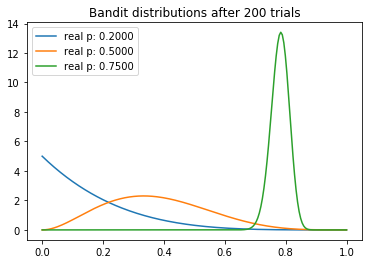

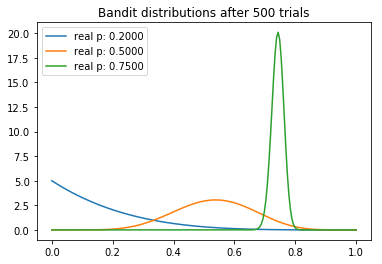

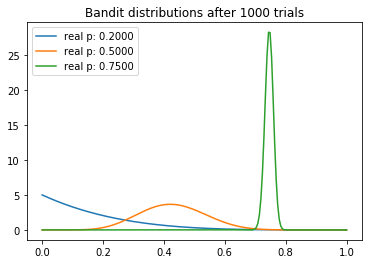

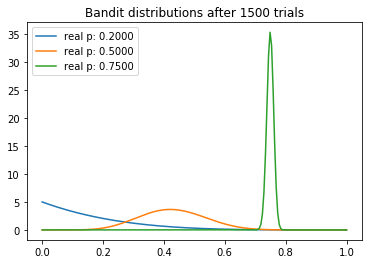

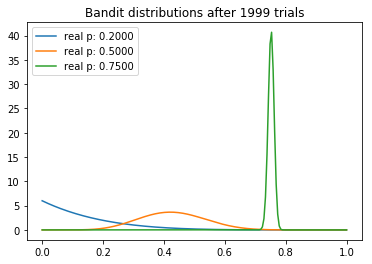

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]

class Bandit(object):
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += 1 - x
        
def plot(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label="real p: %.4f" % b.p)
    plt.title("Bandit distributions after %s trials" % trial)
    plt.legend()
    plt.show()
    
bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
for n in range(NUM_TRIALS):
    best=None
    max_sample=-1
    for b in bandits:
        sample=b.sample()
        if sample>max_sample:
            max_sample=sample
            best=b
    if n in sample_points:
        plot(bandits,n)
    x=best.pull()
    best.update(x)